# Transfer Learning with TensorFlow Part 3: Scaling up (Food vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 100% of the training data (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline is to beat 50.76% accuracy across 101 classes.

In [1]:
!nvidia-smi

Tue Aug 10 12:01:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Let's download helper function
!wget https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learning/main/Utils/helper_functions.py

--2021-08-10 12:01:16--  https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learning/main/Utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10356 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.11K  --.-KB/s    in 0s      

2021-08-10 12:01:16 (85.7 MB/s) - ‘helper_functions.py’ saved [10356/10356]



In [3]:
# Import series of helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

Our goal is to beat original Food101 paper with 10% of training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessing using the image_data_modification.

[notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2021-08-10 12:01:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  71.2MB/s    in 13s     

2021-08-10 12:01:32 (117 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classe

In [6]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_all_10_percent = image_dataset_from_directory(train_dir,
                                                         label_mode="categorical",
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMG_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE,
                                         image_size=IMG_SIZE,
                                         shuffle=False) # don't shuffle the test data f
                                         # for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning with 10% of training data

Here're steps we're going to take:
* Create a `ModelCheckpoint` callback
* Create a data Augmentation layer to build data augmentation right into the model
* Build a headless (no top_layer) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile the model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate 25% of the test dataset, to save trainig time)

In [23]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_best_only=False,
                                                         save_weights_only=True,
                                                         save_freq='epoch')

In [24]:
# Create data augmentation layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# # Create data augmentation stage with horizontal flipping, rotations, zooms, ect
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
  # , preprocessing.Rescaling(1./255) # model EfficientNet has build-in rescale layer :v
], name="data_augmentation_layer")

In [25]:
input_shape = IMG_SIZE+(3,)
input_shape

(224, 224, 3)

In [26]:
# Build a headless (no top_layer) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
# 1. Create inputs layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_shape")

# 2. Create basemodel EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Freeze all layer in base model 

# 3. Pass the inputs to the data augmentation layer
x = data_augmentation(inputs)

# 4. Pass the inputs to the base model layer
x = base_model(x, training=False)

# 5. Pass the inputs to the GlobalAveragePool2D layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_2d_layer")(x)

# 6. Pass the inputs to the Fully connected layer aka output layer
# outputs = tf.keras.layers.Dense(101, activation="softmax")(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), 
                                activation="softmax", 
                                name="output_layer")(x)

# 7. Create a model with inputs and outputs
model = tf.keras.Model(inputs, outputs)

In [27]:
# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_2d_layer (Glo (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [29]:
# Fit the model - Feature extraction
history_all_10_percent = model.fit(train_data_all_10_percent,
                      epochs = 5,
                      validation_data=test_data,
                      validation_steps=int(0.25 * len(test_data)),
                      callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 72s 283ms/step - loss: 3.4826 - accuracy: 0.2469 - val_loss: 2.7231 - val_accuracy: 0.3641
Epoch 2/5
237/237 [==============================] - 64s 269ms/step - loss: 2.3589 - accuracy: 0.4556 - val_loss: 2.2386 - val_accuracy: 0.4486
Epoch 3/5
237/237 [==============================] - 61s 256ms/step - loss: 1.9781 - accuracy: 0.5352 - val_loss: 2.0804 - val_accuracy: 0.4691
Epoch 4/5
237/237 [==============================] - 62s 261ms/step - loss: 1.7641 - accuracy: 0.5743 - val_loss: 2.0147 - val_accuracy: 0.4716
Epoch 5/5
237/237 [==============================] - 59s 248ms/step - loss: 1.6040 - accuracy: 0.6090 - val_loss: 1.9582 - val_accuracy: 0.4806


In [14]:
# Let's evaluate the model check if beat the og paper
model.evaluate(test_data)

790/790 [==============================] - 88s 111ms/step - loss: 1.7306 - accuracy: 0.5492


[1.7305856943130493, 0.5492277145385742]

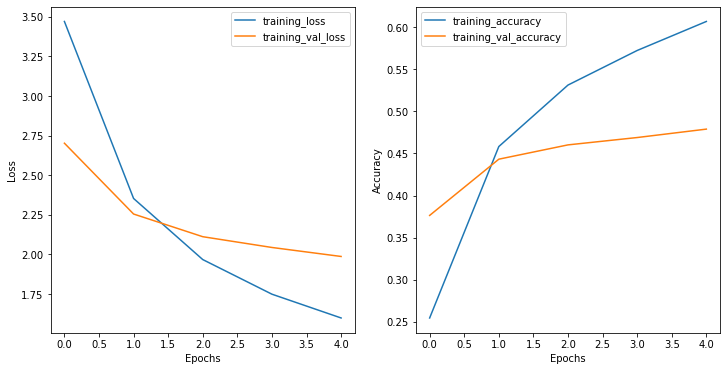

In [15]:
plot_loss_curves(history_all_10_percent)

> 🤔**Question:** What does these curves suggest? -> Hint: ideally, these two curves should be very similar to each other. if not it may suggest that our model is overfitting (performing too well on training data but not on unseen data).

## Fine-tuning

In [16]:
# Unfreeze all of the layers in base model
base_model.trainable = True

# Re-freeze every layers except the last 5 layer in base_model
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [17]:
# Recompile the model with lower learning rate
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine tunning the learning rate should 10x smaller
    metrics=["accuracy"]
)

In [19]:
# check layers in model
for layer in model.layers:
  print(layer.name, layer.trainable)

input_shape True
data_augmentation_layer True
efficientnetb0 True
global_average_2d_layer True
output_layer True


In [22]:
# checkout how many layers in base_model is trainable
for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
blo

In [31]:
checkpoint_path_fine_tune_5_layers = "101_classes_10_percent_data_model_fine_tune_5_layers_checkpoint/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_fine_tune_5_layers,
                                                         monitor="val_accuracy",
                                                         save_best_only=False,
                                                         save_weights_only=True,
                                                         save_freq='epoch')

In [32]:
initial_epochs = 5
# Fine-tuning for more 5 epochs
fine_tuning_epochs = initial_epochs + 5 

In [34]:
# Fine-tuning the last 5 layers for more 5 epochs
history_all_10_percent_fine_tune_5_layers = model.fit(train_data_all_10_percent,
                                                      epochs=fine_tuning_epochs,
                                                      validation_data=test_data,
                                                      validation_steps=int(0.25 * len(test_data)),
                                                      initial_epoch=history_all_10_percent.epoch[-1],
                                                      callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 59s 250ms/step - loss: 1.4919 - accuracy: 0.6284 - val_loss: 1.9241 - val_accuracy: 0.4875
Epoch 6/10
237/237 [==============================] - 59s 246ms/step - loss: 1.3715 - accuracy: 0.6589 - val_loss: 1.8963 - val_accuracy: 0.4956
Epoch 7/10
237/237 [==============================] - 59s 247ms/step - loss: 1.2849 - accuracy: 0.6879 - val_loss: 1.9028 - val_accuracy: 0.4937
Epoch 8/10
237/237 [==============================] - 58s 242ms/step - loss: 1.2131 - accuracy: 0.7005 - val_loss: 1.8675 - val_accuracy: 0.5002
Epoch 9/10
237/237 [==============================] - 56s 235ms/step - loss: 1.1516 - accuracy: 0.7129 - val_loss: 1.8980 - val_accuracy: 0.4910
Epoch 10/10
237/237 [==============================] - 55s 232ms/step - loss: 1.0826 - accuracy: 0.7383 - val_loss: 1.8750 - val_accuracy: 0.4954


In [40]:
# Evaluate the fine-tuned last 5 layers accuracy
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 89s 112ms/step - loss: 1.6450 - accuracy: 0.5602


[1.6450488567352295, 0.5602376461029053]

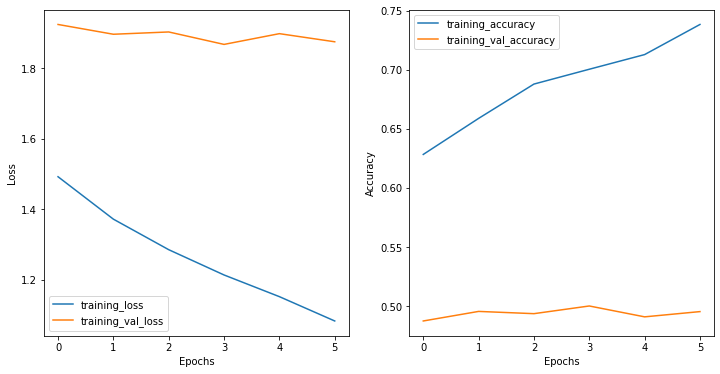

In [36]:
plot_loss_curves(history_all_10_percent_fine_tune_5_layers)

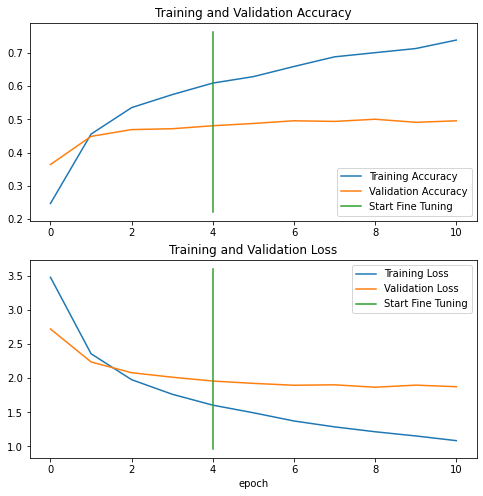

In [37]:
compare_historys(history_all_10_percent, history_all_10_percent_fine_tune_5_layers)

It's seem that model still overfitting 😥

## Saving and loading our model

In [38]:
model.save("drive/MyDrive/Tensorflow Certificate Exam/Weights/101_food_classes_10_percent_save_big_dog_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow Certificate Exam/Weights/101_food_classes_10_percent_save_big_dog_model/assets


In [39]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/Tensorflow Certificate Exam/Weights/101_food_classes_10_percent_save_big_dog_model")

In [41]:
# Evaluate the loaded_model and compare to the pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 91s 113ms/step - loss: 1.6450 - accuracy: 0.5602


[1.6450488567352295, 0.5602376461029053]

In [42]:
all_classes_10_percent_fine_tune_results

([1.6450488567352295, 0.5602376461029053],
 [1.6450488567352295, 0.5602376461029053])

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [43]:
# Make predictions with loaded_model
preds_probs = loaded_model.predict(test_data, verbose=1)

790/790 [==============================] - 63s 78ms/step


In [46]:
len(test_data), 32*len(test_data)

(790, 25280)

In [48]:
preds_probs.shape

(25250, 101)

Our model outputs a prediction probability 

In [52]:
preds = preds_probs.argmax(axis=1)
preds[:10]

array([ 0,  0,  0, 38,  8, 78, 29, 46,  9,  0])

Now've got a predictions array of our model's prediction, to evaluate them, we need to compare them to the ground truth table

In [53]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [55]:
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's prediction

One way to check that our model's predictions array is in the same order as our test label array is to find the accuracy score

In [60]:
# Let's try scikit-learn's accuracy function and see what's it's come up with
import sklearn

sklearn_accuracy = sklearn.metrics.accuracy_score(y_labels,preds)
sklearn_accuracy

0.5602376237623763

In [63]:
# Does this metrics come close to our model's evaluate metrics
import numpy as np

np.isclose(loaded_model_results[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [68]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # changed
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

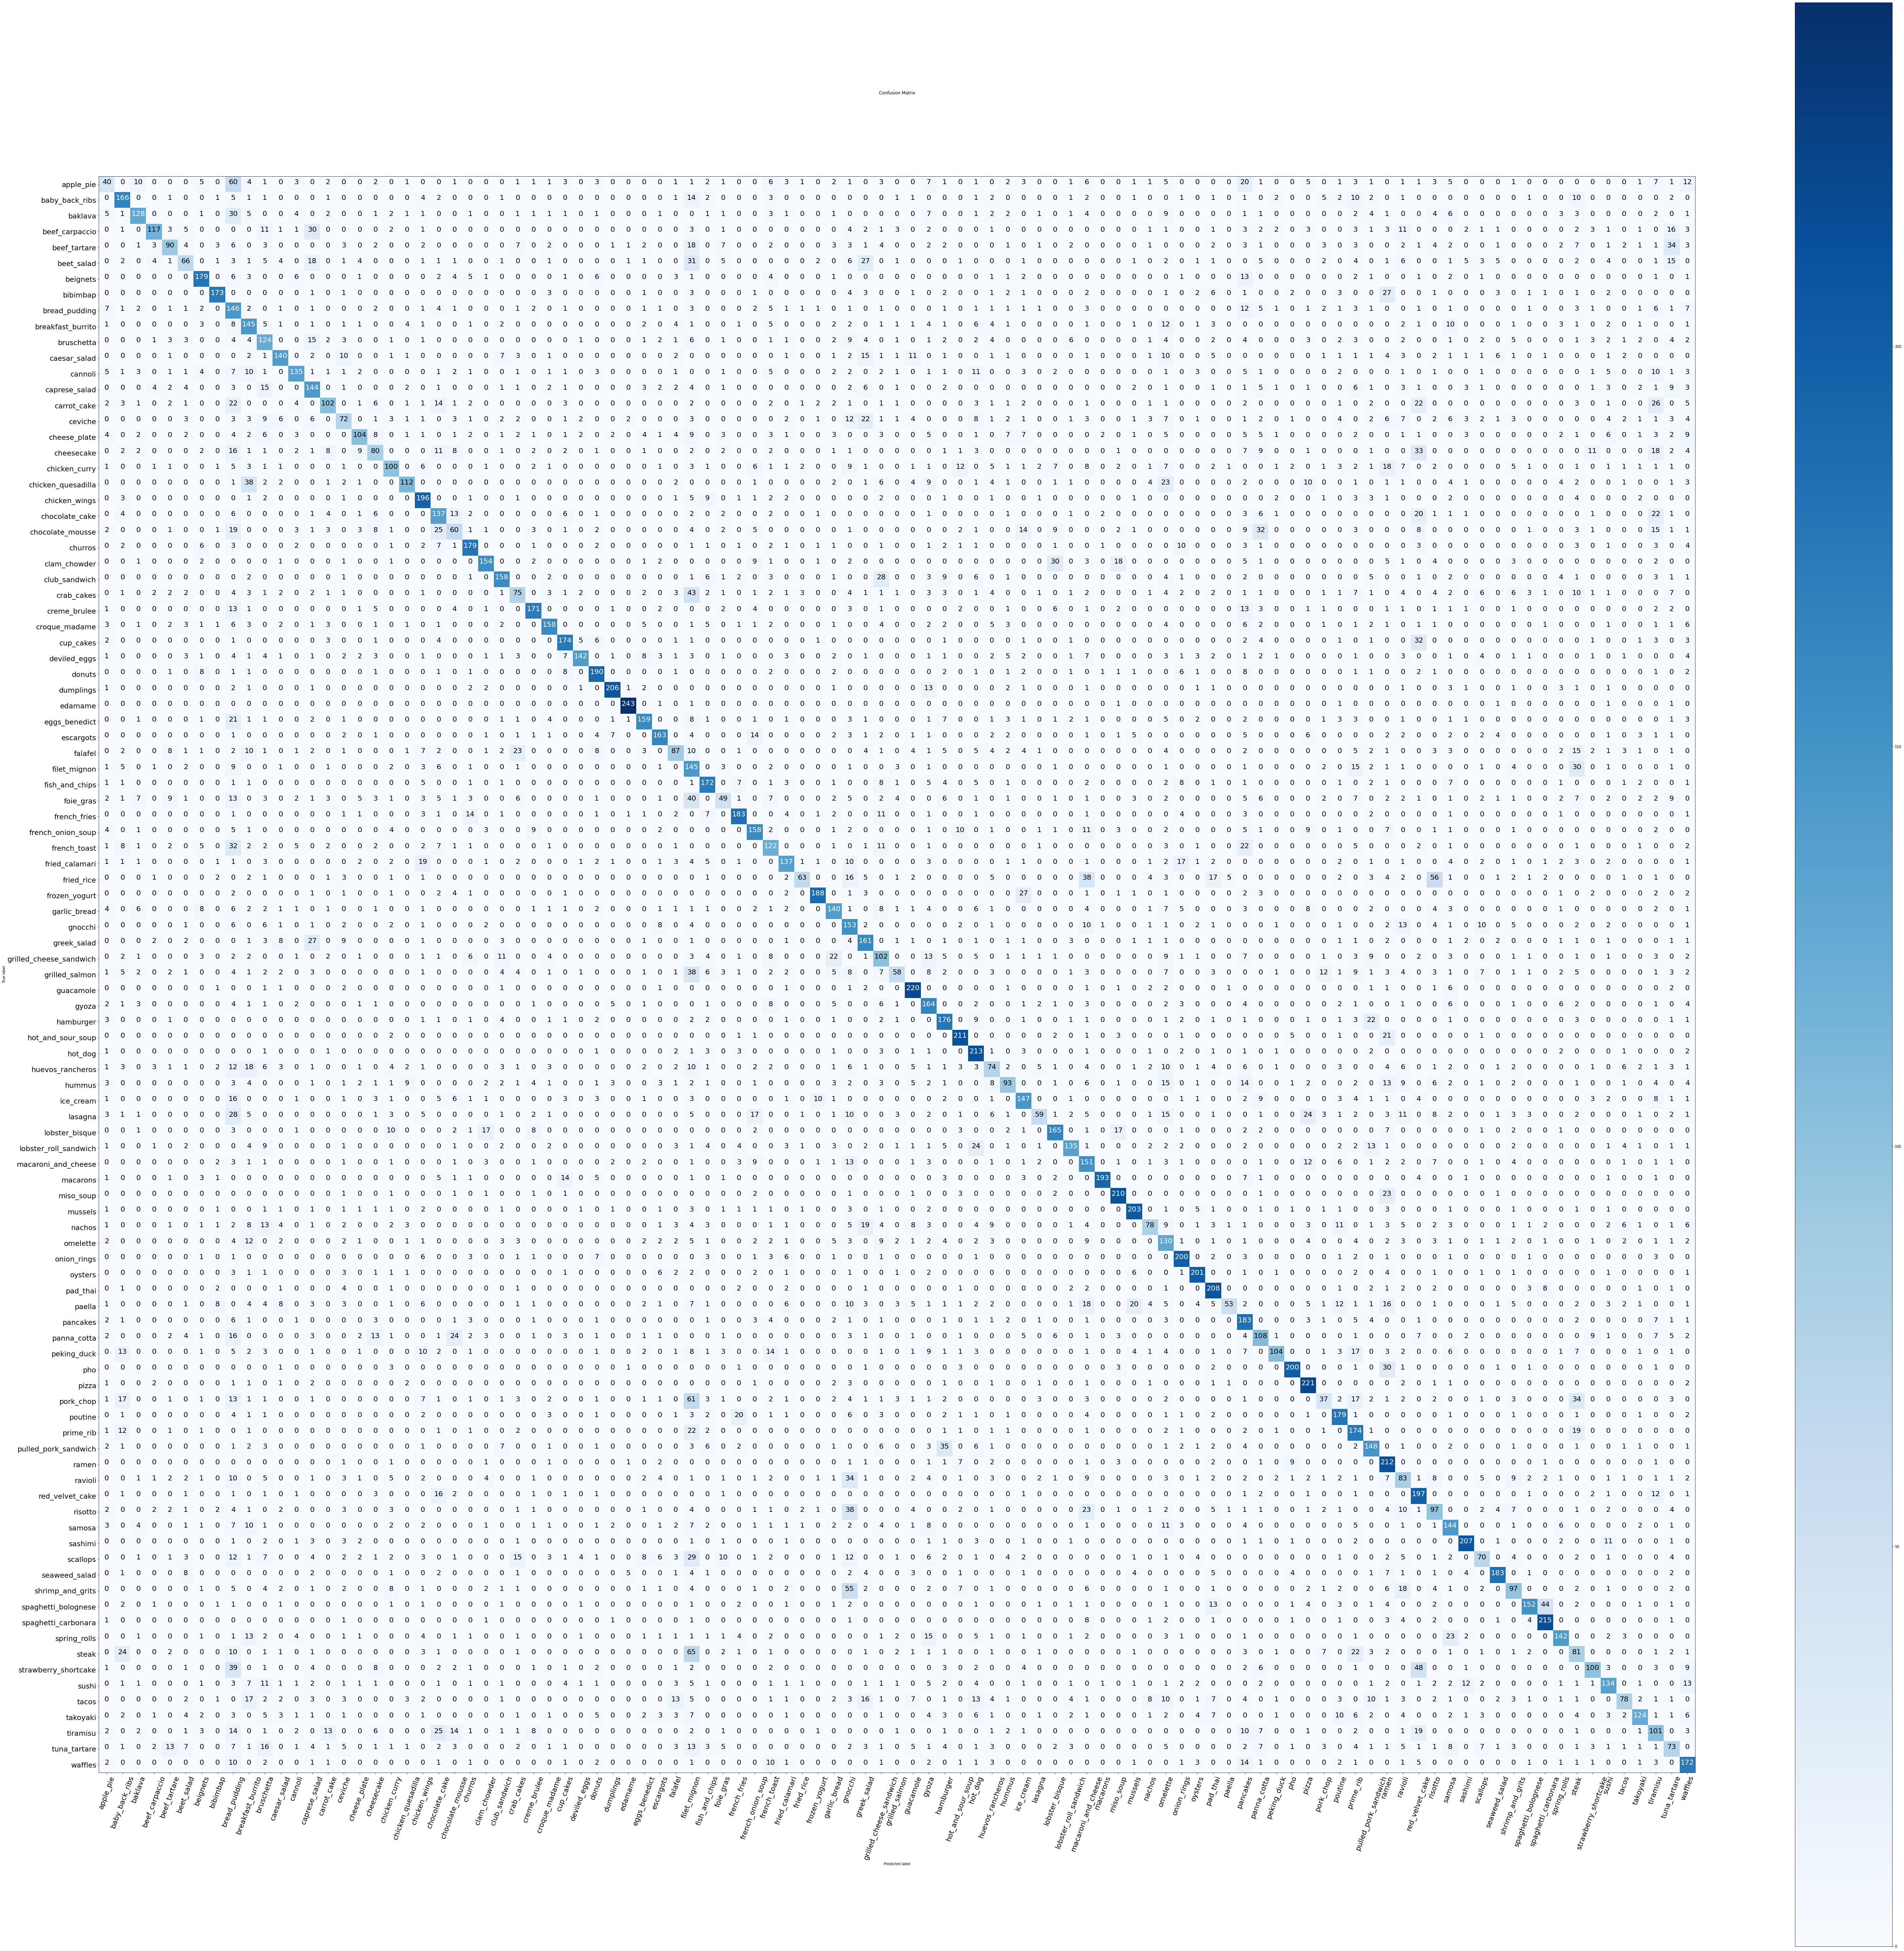

In [70]:
make_confusion_matrix(y_labels, preds, classes=test_data.class_names, figsize=(100,100), text_size=20)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g precision, recall and F1), called classification_report

In [75]:
y_true = y_labels
y_pred = preds

In [80]:
from sklearn.metrics import classification_report

sklearn_classification_report = classification_report(y_true, y_pred, target_names=test_data.class_names)

print(sklearn_classification_report)

                         precision    recall  f1-score   support

              apple_pie       0.31      0.16      0.21       250
         baby_back_ribs       0.56      0.66      0.61       250
                baklava       0.69      0.51      0.59       250
         beef_carpaccio       0.79      0.47      0.59       250
           beef_tartare       0.56      0.36      0.44       250
             beet_salad       0.46      0.26      0.33       250
               beignets       0.71      0.72      0.71       250
               bibimbap       0.84      0.69      0.76       250
          bread_pudding       0.20      0.58      0.29       250
      breakfast_burrito       0.38      0.58      0.46       250
             bruschetta       0.38      0.50      0.43       250
           caesar_salad       0.67      0.56      0.61       250
                cannoli       0.71      0.54      0.62       250
          caprese_salad       0.47      0.58      0.52       250
            carrot_cake 

In [ ]:
sklearn_classification_report_dict = classification_report(y_true, y_pred, 
                                                      target_names=test_data.class_names,
                                                      output_dict=True)
sklearn_classification_report_dict

Let's convert the classification_report to data frame for easy to analize

In [88]:
import pandas as pd

df = pd.DataFrame(sklearn_classification_report_dict)
dff = df.T
dff.head()

precision  recall  f1-score  support
apple_pie        0.305344   0.160  0.209974    250.0
baby_back_ribs   0.562712   0.664  0.609174    250.0
baklava          0.688172   0.512  0.587156    250.0
beef_carpaccio   0.785235   0.468  0.586466    250.0
beef_tartare     0.559006   0.360  0.437956    250.0

In [89]:
sklearn_classification_report_dict["pho"]

{'f1-score': 0.8333333333333333,
 'precision': 0.8695652173913043,
 'recall': 0.8,
 'support': 250}

Let's plot all F1 score

In [96]:
# Create emty dictionary
class_f1_scores = {}
# Loops through dictionary 
for k, v in sklearn_classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[k] = v['f1-score']
class_f1_scores

{'apple_pie': 0.2099737532808399,
 'baby_back_ribs': 0.6091743119266055,
 'baklava': 0.5871559633027523,
 'beef_carpaccio': 0.5864661654135338,
 'beef_tartare': 0.437956204379562,
 'beet_salad': 0.3341772151898734,
 'beignets': 0.714570858283433,
 'bibimbap': 0.7587719298245613,
 'bread_pudding': 0.2928786359077231,
 'breakfast_burrito': 0.46251993620414666,
 'bruschetta': 0.43205574912891986,
 'caesar_salad': 0.6100217864923748,
 'cannoli': 0.6150341685649202,
 'caprese_salad': 0.5189189189189188,
 'carrot_cake': 0.4987775061124694,
 'ceviche': 0.34285714285714286,
 'cheese_plate': 0.5135802469135803,
 'cheesecake': 0.37383177570093457,
 'chicken_curry': 0.46296296296296297,
 'chicken_quesadilla': 0.5628140703517588,
 'chicken_wings': 0.6758620689655173,
 'chocolate_cake': 0.4972776769509982,
 'chocolate_mousse': 0.28846153846153844,
 'churros': 0.7203219315895373,
 'clam_chowder': 0.676923076923077,
 'club_sandwich': 0.656964656964657,
 'crab_cakes': 0.35377358490566035,
 'creme_brul

In [101]:
# Turn f1-score into DataFrame for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()), "f1_score":list(class_f1_scores.values())}).sort_values("f1_score",ascending=False)

In [102]:
f1_scores

class_names  f1_score
33           edamame  0.958580
63          macarons  0.855876
32         dumplings  0.851240
75               pho  0.833333
86           sashimi  0.821429
..               ...       ...
8      bread_pudding  0.292879
22  chocolate_mousse  0.288462
39         foie_gras  0.267760
77         pork_chop  0.214493
0          apple_pie  0.209974

[101 rows x 2 columns]

AttributeError: ignored

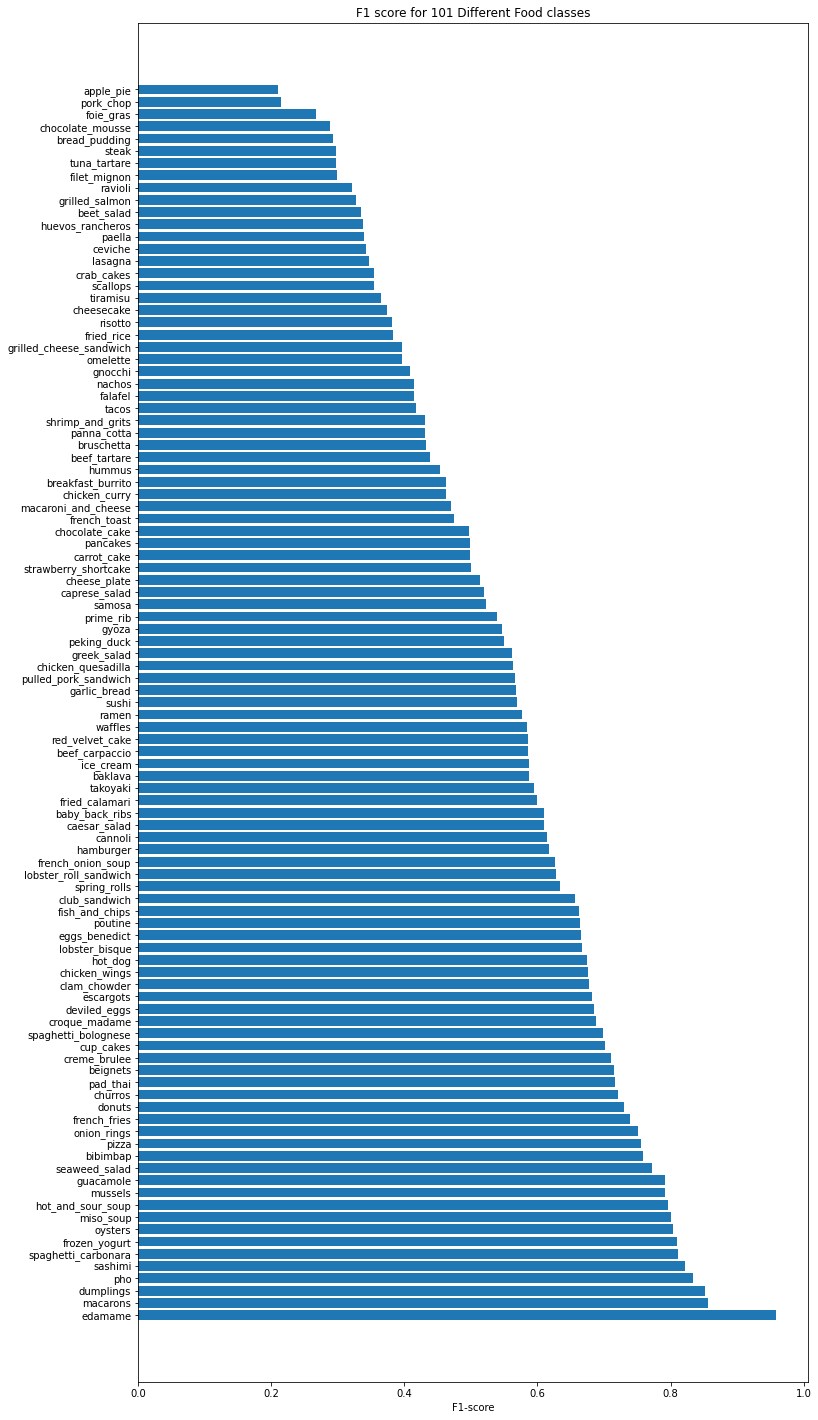

In [118]:
import matplotlib.pyplot as plt

foods = list(f1_scores.class_names)
scores = list(f1_scores.f1_score)
fig, ax = plt.subplots(figsize=(12,25))

hbars = ax.barh(foods, scores)
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food classes")
# set number on top of the bar
ax.bar_label(hbars, fmt="%.2f")
ax.invert_yaxis(); # order the plot by descending because the data is ascending
plt.show()

## Visualizing on custom image

Now, this is the real test, how does our goes on food images not even in our test dataset?

To visualize our model's prediction on our own images, we'll need a function to load and preprocess images, spcecifically:
* Read in a target image filepath using `tf.io.read_file()`
* Turn images into Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scale the image (normalized if needed)

In [120]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes to specific shape
  (img_shape, image_shape, channels=3)

  Args: 
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? yes/no
  if scale:
    return img/255.
  else:
    return img

Let's write some code:
1. Load a few random images from the test data set.
2. Make predictions on the loaded images.
3. Plot the original image(s) along with the model's prediction. 

In [164]:
import os
import random

def predict_random_images(model, data_dir, class_names):
  plt.figure(figsize=(17, 10))
  for i in range (4):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(data_dir+"/"+class_name))
    filepath = data_dir +"/"+ class_name + "/" + filename
    # print(filepath)
    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    input_img = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(input_img)
    pred_class = class_names[pred_prob.argmax()]
    
    # Plot the predicted image 
    plt.subplot(2, 2, (i+1))
    plt.imshow(img/255.)

    title_color = 'g' if class_name == pred_class else 'r'
    plt.title(f"Actual {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", color=title_color)
    plt.axis(False)

  plt.show()

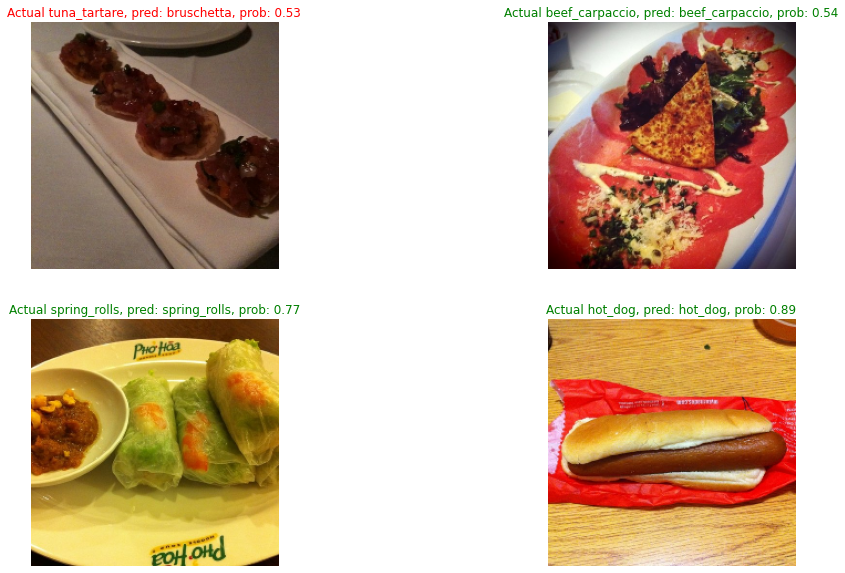

In [170]:
predict_random_images(loaded_model, test_dir, class_names=test_data.class_names)

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following
1. Get all of the image file paths in the test dataset using `list_fille()` method.
2. Create a pandas DartaFrame of the image filepaths, ground truth tables, predicted class (from our model), max prediction probabilities.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but has wrong prediction.

In [231]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath)
len(filepaths)

25250

In [181]:
class_names = test_data.class_names
# class_names

In [233]:
# 2. Create a DataFrame
import pandas as pd

pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": preds,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_classname": [class_names[x] for x in y_labels],
                        "y_pred_classname": [class_names[x] for x in preds]})
pred_df.to_csv('out.csv')
pred_df.head()

img_path  ...  y_pred_classname
0  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         apple_pie
1  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         apple_pie
2  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         apple_pie
3  tf.Tensor(b'/content/101_food_classes_10_perce...  ...    fish_and_chips
4  tf.Tensor(b'/content/101_food_classes_10_perce...  ...     bread_pudding

[5 rows x 6 columns]

In [234]:
# 3. Find out in DataFrame which prediction is wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

In [235]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head()

img_path  ...  pred_correct
23631  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
23797  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
18001  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
11642  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False
10847  tf.Tensor(b'/content/101_food_classes_10_perce...  ...         False

[5 rows x 7 columns]

tf.Tensor(b'/content/101_food_classes_10_percent/test/strawberry_shortcake/2926631.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/101_food_classes_10_percent/test/sushi/1659357.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/101_food_classes_10_percent/test/pancakes/1008491.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/101_food_classes_10_percent/test/garlic_bread/2957596.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/101_food_classes_10_percent/test/fried_calamari/2294819.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/101_food_classes_10_percent/test/risotto/493827.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/101_food_classes_10_percent/test/macarons/1951681.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/101_food_classes_10_percent/test/chocolate_mousse/3216902.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/101_food_classes_10_percent/test/chocolate_mousse/1402394.jpg', shape=(), dtype=string)


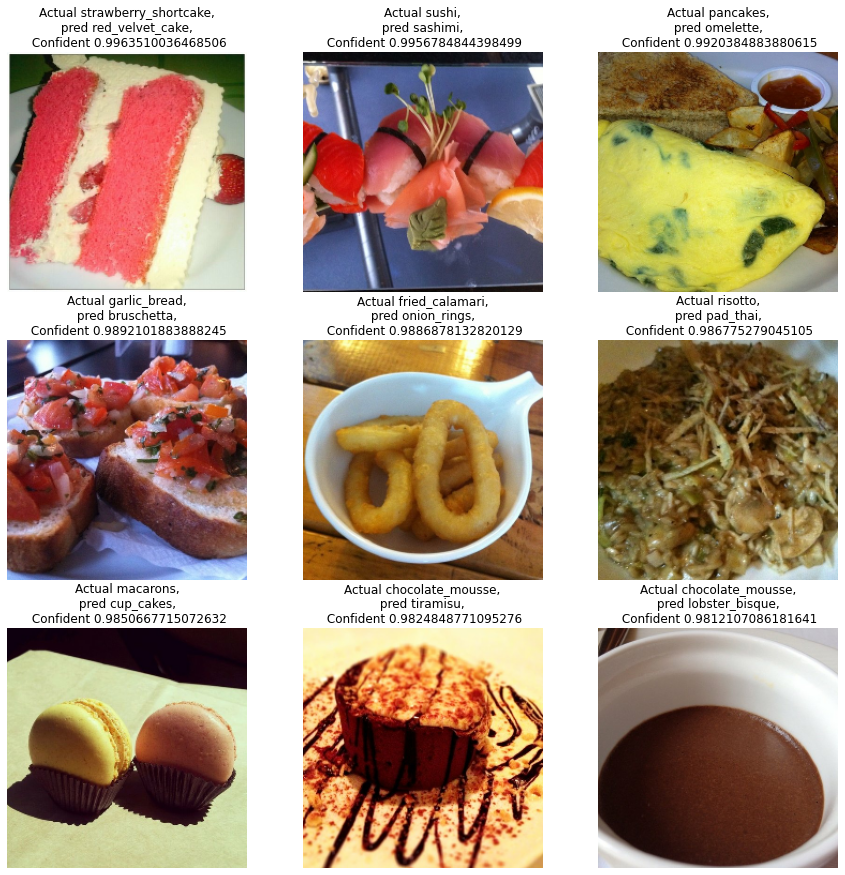

In [236]:
# 5. Visualize the test data samples which have the wrong prediction but with highest probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 15))
count = 1
for i, row in top_100_wrong[start_index:start_index+images_to_view].iterrows():
  plt.subplot(3, 3, count)
  count+=1
  print(row["img_path"])
  img = load_and_prep_image(row["img_path"], scale=False)
  plt.imshow(img/255.)
  plt.title(f'Actual {row["y_true_classname"]},\n pred {row["y_pred_classname"]}, \n Confident {row["pred_conf"]}')
  plt.axis(False)
plt.show()

In [ ]:
def predict_random_image(dataset, model):
  """
  Choose a random image and then predict it
  """
  class_names = dataset.class_names
  plt.figure(figsize=(8,8))
  for images, labels in dataset.take(1):
    # Plot the random image
    rand_img = images[0]
    random_label = labels[0]
    rand_label = tf.argmax(random_label, axis=0)
    plt.imshow(rand_img.numpy().astype("uint8"))
    plt.title(class_names[rand_label])
    plt.axis(False)

    # Plot the prediction
    predict = model.predict(tf.expand_dims(rand_img, axis=0))
    pred = np.argmax(predict, axis=1)
    color =  "green" if pred[0] == rand_label else "red"
    plt.title(f"predicted: {class_names[pred[0]]}, right label is {class_names[rand_label]}", color=color)
    plt.show()